Loading and processing dataset...
Found 4224 audio files
Emotions: {'sad', 'neutral', 'angry', 'disgust', 'fear', 'pleasant_surprise', 'happy'}
Processing file 1/4224
Processing file 51/4224
Processing file 101/4224
Processing file 151/4224
Processing file 201/4224
Processing file 251/4224
Processing file 301/4224
Processing file 351/4224
Processing file 401/4224
Processing file 451/4224
Processing file 501/4224
Processing file 551/4224
Processing file 601/4224
Processing file 651/4224
Processing file 701/4224
Processing file 751/4224
Processing file 801/4224
Processing file 851/4224
Processing file 901/4224
Processing file 951/4224
Processing file 1001/4224
Processing file 1051/4224
Processing file 1101/4224
Processing file 1151/4224
Processing file 1201/4224
Processing file 1251/4224
Processing file 1301/4224
Processing file 1351/4224
Processing file 1401/4224
Processing file 1451/4224
Processing file 1501/4224
Processing file 1551/4224
Processing file 1601/4224
Processing file 1651/

CNN Accuracy: 0.8817

=== MODEL EVALUATION ===

Random Forest:
Accuracy: 0.8142

Classification Report:
                   precision    recall  f1-score   support

            angry       0.80      0.85      0.82       118
          disgust       0.75      0.85      0.79       118
             fear       0.88      0.83      0.85       119
            happy       0.81      0.74      0.77       117
          neutral       0.85      0.88      0.86       138
pleasant_surprise       0.73      0.79      0.76       118
              sad       0.93      0.75      0.83       117

         accuracy                           0.81       845
        macro avg       0.82      0.81      0.81       845
     weighted avg       0.82      0.81      0.81       845


Logistic Regression:
Accuracy: 0.7030

Classification Report:
                   precision    recall  f1-score   support

            angry       0.72      0.70      0.71       118
          disgust       0.74      0.76      0.75       118
   

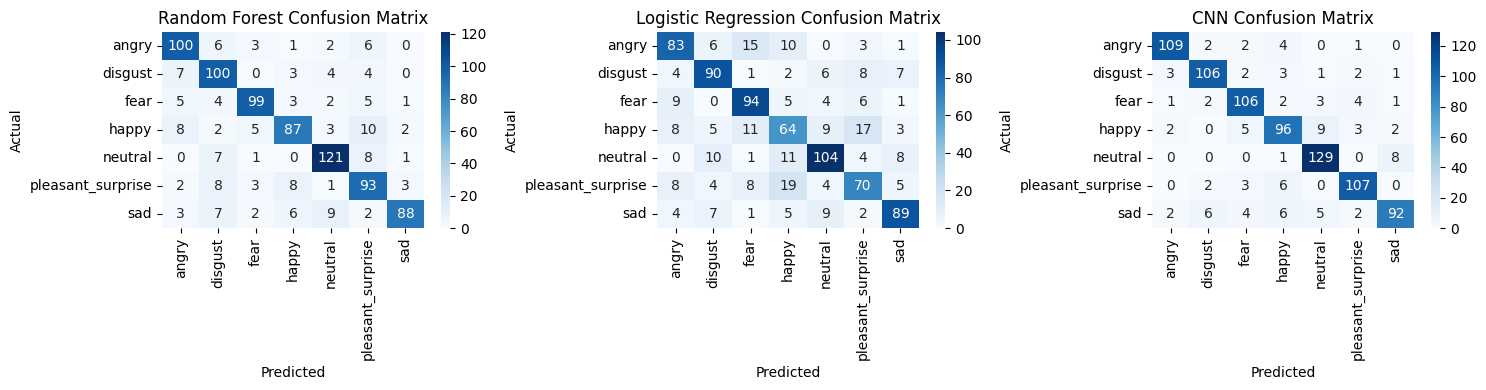

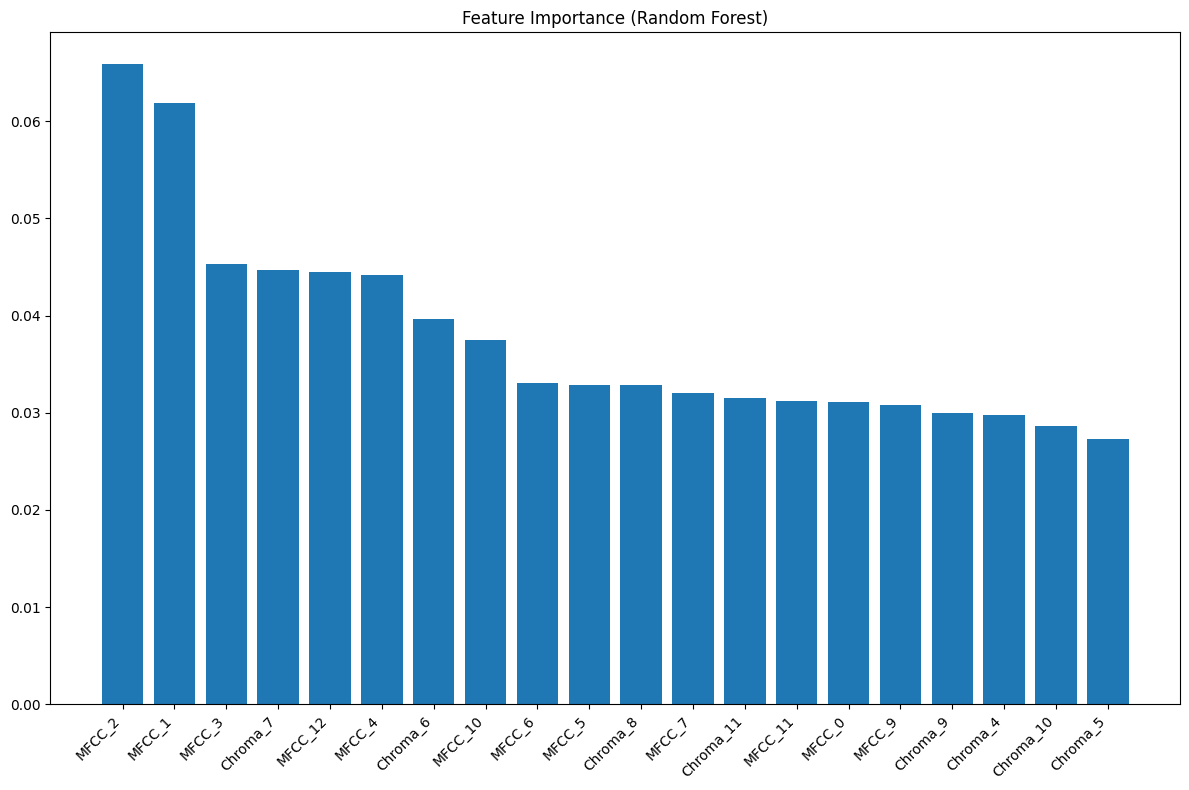


Training completed! Models and artifacts saved.


In [4]:
# Speech Emotion Recognition System
# Complete implementation with preprocessing, feature extraction, model training, and deployment

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
import warnings
warnings.filterwarnings('ignore')

class AudioPreprocessor:
    """Class for audio preprocessing operations"""
    
    def __init__(self, target_sr=16000, duration=3.0):
        self.target_sr = target_sr
        self.duration = duration
        self.target_length = int(target_sr * duration)
    
    def load_and_preprocess(self, file_path):
        """Load and preprocess audio file"""
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)
            
            # Convert to mono if stereo
            if len(audio.shape) > 1:
                audio = librosa.to_mono(audio)
            
            # Resample to target sample rate
            if sr != self.target_sr:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)
            
            # Trim silence
            audio, _ = librosa.effects.trim(audio, top_db=20)
            
            # Normalize audio
            audio = librosa.util.normalize(audio)
            
            # Pad or trim to fixed length
            if len(audio) > self.target_length:
                audio = audio[:self.target_length]
            else:
                audio = np.pad(audio, (0, self.target_length - len(audio)), mode='constant')
            
            return audio
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

class FeatureExtractor:
    """Class for extracting audio features"""
    
    def __init__(self, sr=16000, n_mfcc=13, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
    
    def extract_mfcc(self, audio):
        """Extract MFCC features"""
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=self.n_mfcc,
                                   n_fft=self.n_fft, hop_length=self.hop_length)
        return np.mean(mfcc.T, axis=0)
    
    def extract_mel_spectrogram(self, audio):
        """Extract Mel-spectrogram"""
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr,
                                                 n_fft=self.n_fft, hop_length=self.hop_length,
                                                 n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    
    def extract_chroma(self, audio):
        """Extract Chroma features"""
        try:
            # Try newer librosa version first
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.sr,
                                               n_fft=self.n_fft, hop_length=self.hop_length)
        except AttributeError:
            try:
                # Try older librosa version
                chroma = librosa.feature.chroma(y=audio, sr=self.sr,
                                               n_fft=self.n_fft, hop_length=self.hop_length)
            except AttributeError:
                # Fallback: compute chroma manually
                stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
                chroma = librosa.feature.chroma_stft(S=np.abs(stft), sr=self.sr)
        
        return np.mean(chroma.T, axis=0)
    
    def extract_spectral_features(self, audio):
        """Extract spectral features"""
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=self.sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.sr)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
        
        return np.array([
            np.mean(spectral_centroids),
            np.std(spectral_centroids),
            np.mean(spectral_rolloff),
            np.std(spectral_rolloff),
            np.mean(spectral_bandwidth),
            np.std(spectral_bandwidth),
            np.mean(zero_crossing_rate),
            np.std(zero_crossing_rate)
        ])
    
    def extract_all_features(self, audio):
        """Extract all features and combine them"""
        mfcc = self.extract_mfcc(audio)
        chroma = self.extract_chroma(audio)
        spectral = self.extract_spectral_features(audio)
        
        # Combine all features
        features = np.concatenate([mfcc, chroma, spectral])
        return features

class DatasetLoader:
    """Class for loading and organizing the dataset"""
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.preprocessor = AudioPreprocessor()
        self.feature_extractor = FeatureExtractor()
        
    def load_dataset(self):
        """Load dataset from folder structure"""
        emotions = ['sad', 'pleasant_surprise', 'neutral', 'happy', 'fear', 'disgust', 'angry']
        
        audio_files = []
        labels = []
        
        for emotion in emotions:
            emotion_path = os.path.join(self.data_path, emotion)
            if os.path.exists(emotion_path):
                for file in os.listdir(emotion_path):
                    if file.endswith('.wav') or file.endswith('.mp3'):
                        audio_files.append(os.path.join(emotion_path, file))
                        labels.append(emotion)
        
        return audio_files, labels
    
    def process_dataset(self):
        """Process entire dataset and extract features"""
        audio_files, labels = self.load_dataset()
        
        print(f"Found {len(audio_files)} audio files")
        print(f"Emotions: {set(labels)}")
        
        # Extract features
        features_list = []
        spectrograms = []
        processed_labels = []
        
        for i, (file_path, label) in enumerate(zip(audio_files, labels)):
            if i % 50 == 0:
                print(f"Processing file {i+1}/{len(audio_files)}")
            
            # Preprocess audio
            audio = self.preprocessor.load_and_preprocess(file_path)
            
            if audio is not None:
                # Extract features for classical ML
                features = self.feature_extractor.extract_all_features(audio)
                features_list.append(features)
                
                # Extract mel-spectrogram for deep learning
                mel_spec = self.feature_extractor.extract_mel_spectrogram(audio)
                spectrograms.append(mel_spec)
                
                processed_labels.append(label)
        
        return np.array(features_list), np.array(spectrograms), np.array(processed_labels)

class EmotionClassifier:
    """Main class for emotion classification"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.classical_models = {}
        self.deep_models = {}
        
    def prepare_data(self, features, spectrograms, labels):
        """Prepare data for training"""
        # Encode labels
        encoded_labels = self.label_encoder.fit_transform(labels)
        
        # Split data
        (X_features_train, X_features_test, 
         X_spec_train, X_spec_test, 
         y_train, y_test) = train_test_split(
            features, spectrograms, encoded_labels, 
            test_size=0.2, random_state=42, stratify=encoded_labels
        )
        
        # Scale features for classical ML
        X_features_train_scaled = self.scaler.fit_transform(X_features_train)
        X_features_test_scaled = self.scaler.transform(X_features_test)
        
        # Prepare spectrograms for deep learning
        X_spec_train = X_spec_train.reshape(X_spec_train.shape[0], X_spec_train.shape[1], X_spec_train.shape[2], 1)
        X_spec_test = X_spec_test.reshape(X_spec_test.shape[0], X_spec_test.shape[1], X_spec_test.shape[2], 1)
        
        # Convert labels to categorical for deep learning
        y_train_cat = to_categorical(y_train)
        y_test_cat = to_categorical(y_test)
        
        return (X_features_train_scaled, X_features_test_scaled, 
                X_spec_train, X_spec_test, 
                y_train, y_test, y_train_cat, y_test_cat)
    
    def train_classical_models(self, X_train, y_train, X_test, y_test):
        """Train classical ML models"""
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred
            }
            
            print(f"{name} Accuracy: {accuracy:.4f}")
            
            # Save model
            joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')
        
        self.classical_models = results
        return results
    
    def create_cnn_model(self, input_shape, num_classes):
        """Create CNN model for spectrogram classification"""
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        return model
    
    def train_deep_models(self, X_train, y_train, X_test, y_test):
        """Train deep learning models"""
        num_classes = len(np.unique(y_train.argmax(axis=1)))
        input_shape = X_train.shape[1:]
        
        # Create and train CNN
        print("Training CNN model...")
        cnn_model = self.create_cnn_model(input_shape, num_classes)
        
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001
        )
        
        # Train CNN
        history = cnn_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Evaluate CNN
        cnn_pred = cnn_model.predict(X_test)
        cnn_accuracy = accuracy_score(y_test.argmax(axis=1), cnn_pred.argmax(axis=1))
        
        print(f"CNN Accuracy: {cnn_accuracy:.4f}")
        
        # Save model
        cnn_model.save('cnn_emotion_model.h5')
        
        self.deep_models['CNN'] = {
            'model': cnn_model,
            'accuracy': cnn_accuracy,
            'history': history,
            'predictions': cnn_pred.argmax(axis=1)
        }
        
        return self.deep_models
    
    def evaluate_models(self, y_true, predictions_dict):
        """Evaluate and compare all models"""
        print("\n=== MODEL EVALUATION ===")
        
        for model_name, pred_data in predictions_dict.items():
            if isinstance(pred_data, dict):
                predictions = pred_data['predictions']
                accuracy = pred_data['accuracy']
            else:
                predictions = pred_data
                accuracy = accuracy_score(y_true, predictions)
            
            print(f"\n{model_name}:")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_true, predictions, 
                                      target_names=self.label_encoder.classes_))
    
    def plot_confusion_matrices(self, y_true, predictions_dict):
        """Plot confusion matrices for all models"""
        n_models = len(predictions_dict)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        if n_models == 1:
            axes = [axes]
        
        for idx, (model_name, pred_data) in enumerate(predictions_dict.items()):
            if isinstance(pred_data, dict):
                predictions = pred_data['predictions']
            else:
                predictions = pred_data
            
            cm = confusion_matrix(y_true, predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.label_encoder.classes_,
                       yticklabels=self.label_encoder.classes_,
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
        
        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance for Random Forest"""
        if 'Random Forest' in self.classical_models:
            rf_model = self.classical_models['Random Forest']['model']
            
            # Create feature names
            feature_names = (
                [f'MFCC_{i}' for i in range(13)] + 
                [f'Chroma_{i}' for i in range(12)] + 
                ['Spectral_Centroid_Mean', 'Spectral_Centroid_Std',
                 'Spectral_Rolloff_Mean', 'Spectral_Rolloff_Std',
                 'Spectral_Bandwidth_Mean', 'Spectral_Bandwidth_Std',
                 'ZCR_Mean', 'ZCR_Std']
            )
            
            importances = rf_model.feature_importances_
            indices = np.argsort(importances)[::-1][:20]  # Top 20 features
            
            plt.figure(figsize=(12, 8))
            plt.title('Feature Importance (Random Forest)')
            plt.bar(range(20), importances[indices])
            plt.xticks(range(20), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()

# Main execution
def main():
    # Initialize the emotion classifier
    classifier = EmotionClassifier()
    
    # Load and process dataset
    dataset_loader = DatasetLoader('data')  # Update with your data path
    
    print("Loading and processing dataset...")
    features, spectrograms, labels = dataset_loader.process_dataset()
    
    print(f"Dataset loaded: {len(features)} samples")
    print(f"Feature shape: {features.shape}")
    print(f"Spectrogram shape: {spectrograms.shape}")
    
    # Prepare data
    (X_features_train, X_features_test, 
     X_spec_train, X_spec_test, 
     y_train, y_test, 
     y_train_cat, y_test_cat) = classifier.prepare_data(features, spectrograms, labels)
    
    # Train classical models
    print("\n=== TRAINING CLASSICAL MODELS ===")
    classical_results = classifier.train_classical_models(
        X_features_train, y_train, X_features_test, y_test
    )
    
    # Train deep learning models
    print("\n=== TRAINING DEEP LEARNING MODELS ===")
    deep_results = classifier.train_deep_models(
        X_spec_train, y_train_cat, X_spec_test, y_test_cat
    )
    
    # Combine all predictions for evaluation
    all_predictions = {}
    all_predictions.update(classical_results)
    
    # Convert deep learning predictions to match classical format
    for name, result in deep_results.items():
        all_predictions[name] = {
            'predictions': result['predictions'],
            'accuracy': result['accuracy']
        }
    
    # Evaluate models
    classifier.evaluate_models(y_test, all_predictions)
    
    # Plot confusion matrices
    classifier.plot_confusion_matrices(y_test, all_predictions)
    
    # Plot feature importance
    classifier.plot_feature_importance()
    
    # Save label encoder and scaler
    joblib.dump(classifier.label_encoder, 'label_encoder.pkl')
    joblib.dump(classifier.scaler, 'scaler.pkl')
    
    print("\nTraining completed! Models and artifacts saved.")

if __name__ == "__main__":
    main()